# Audio Classification of Using MobileNet

This project focuses on developing an efficient audio classification system to recognize Farsi spoken digits (0–9) using the MobileNet architecture. Audio recordings are converted into spectrograms, which are processed by MobileNet—a lightweight and computationally efficient neural network ideal for mobile and embedded systems. By training on a diverse dataset of Farsi digits, the model aims to deliver accurate and real-time spoken number recognition, enabling robust audio-based interaction.

In [ ]:
!gdown https://drive.google.com/uc?id=10lkhSsj5xG3jOkuIb6CB416MfKKPybVX

Downloading...
From (original): https://drive.google.com/uc?id=10lkhSsj5xG3jOkuIb6CB416MfKKPybVX
From (redirected): https://drive.google.com/uc?id=10lkhSsj5xG3jOkuIb6CB416MfKKPybVX&confirm=t&uuid=285b5ccf-dff5-40f2-8b14-9a7d676930ad
To: /content/Dataset-No-Augmentation.zip
100% 215M/215M [00:01<00:00, 183MB/s]


In [ ]:
!unzip -q /content/Dataset-No-Augmentation.zip

In [ ]:
!pip install tensorflow_io

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '20'

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from pathlib import Path
import tensorflow_hub as hub
import tensorflow_io as tfio #Efficient processing of audio clips
from IPython.display import Audio, display

## Loading data

We leverage YAMNet, a pre-trained audio event detection model available from TensorFlow Hub, to extract spectrograms from audio recordings of Farsi numbers (0-9). The high-quality spectrograms generated by YAMNet serve as the input for our MobileNet-based classification model.

In [ ]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [ ]:
import os
import random
from pathlib import Path
from sklearn.model_selection import train_test_split

paths = Path().glob('*/*.wav')
train_paths = [str(path.absolute()) for path in paths]
train_labels = [int(x.split(os.path.sep)[-1].split('_')[0]) for x in train_paths]

print(len(train_paths), 'Training data!')

combined = list(zip(train_paths, train_labels))
random.shuffle(combined)

train_paths[:], train_labels[:] = zip(*combined)

train_size = 0.9
train_paths, test_paths, train_labels, test_labels = train_test_split(
    train_paths, train_labels, train_size=train_size, random_state=42
)

print(len(train_paths), 'Training samples!')
print(len(test_paths), 'Testing samples!')

3682 Training data!
3313 Training samples!
369 Testing samples!


Let's visualize some data

## Visuailize data

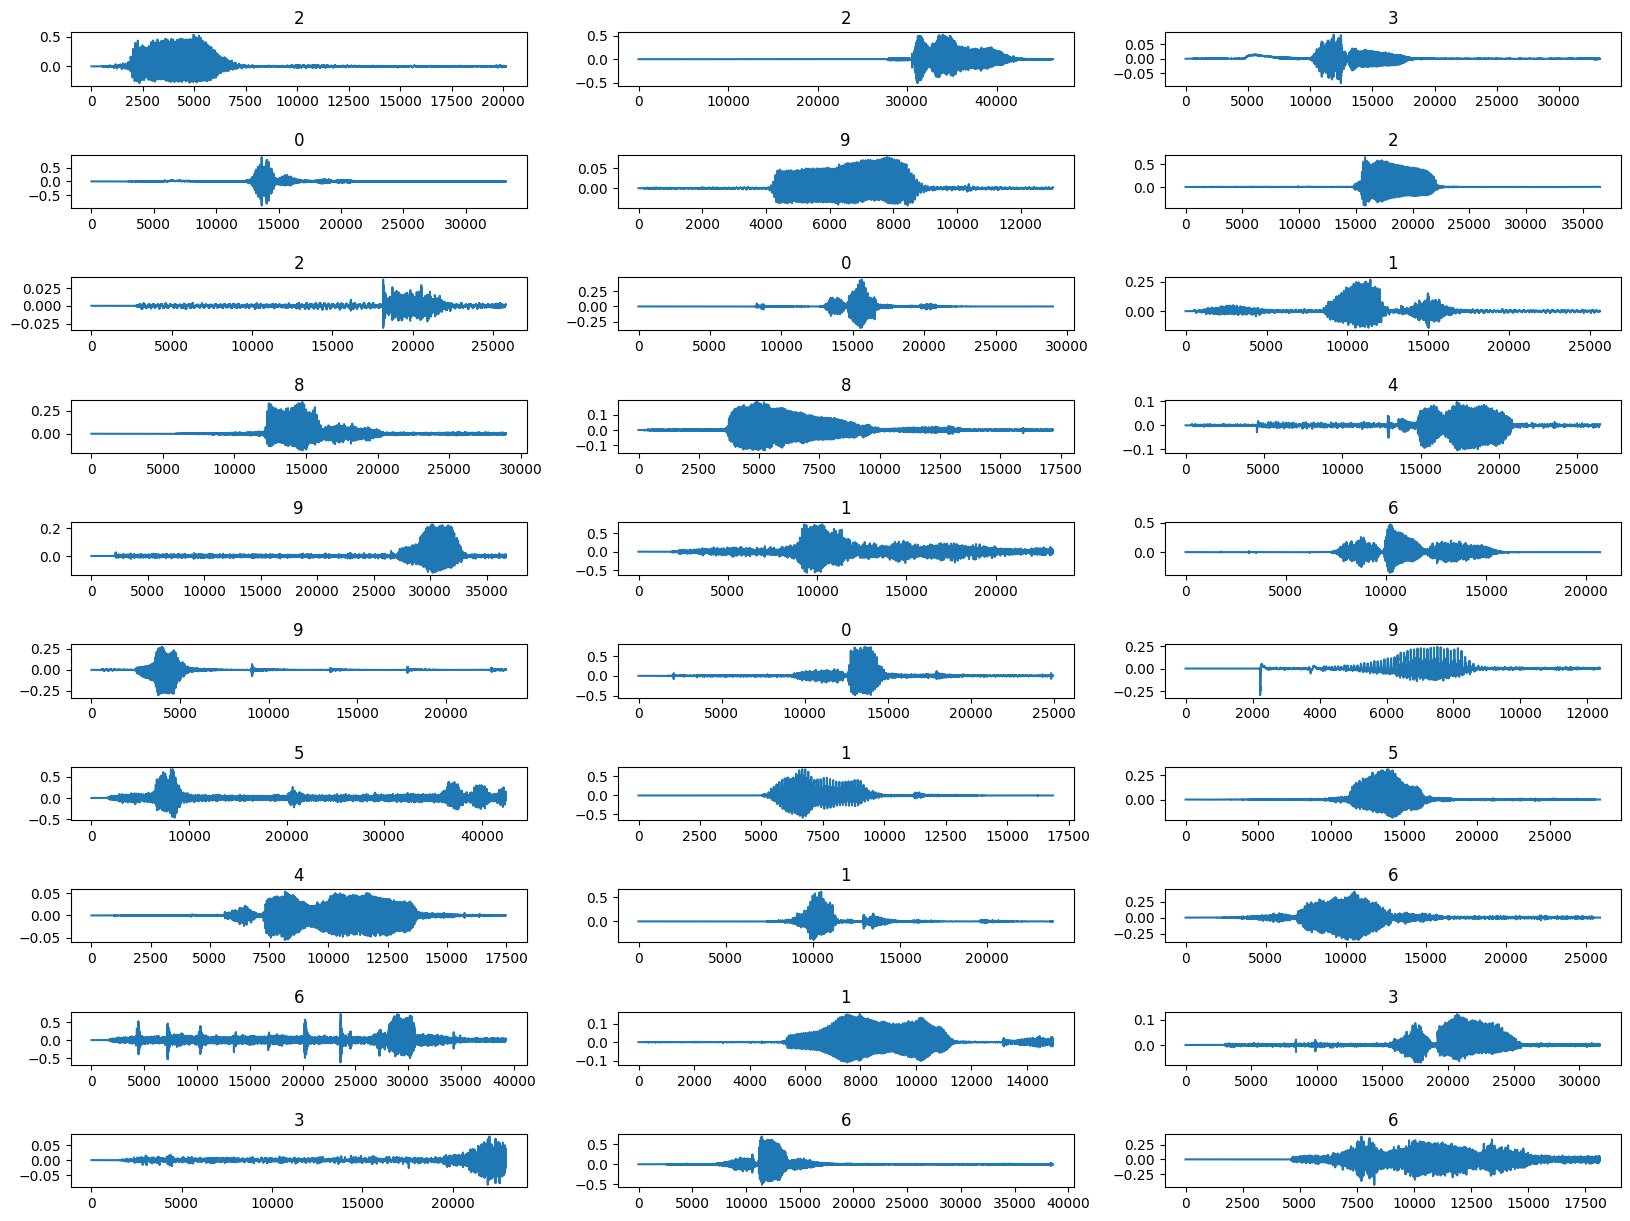

In [ ]:
fig = plt.figure(figsize=(20, 15))
for i, (path, lbl) in enumerate(zip(train_paths, train_labels)):
    if i >= 30: break

    ax = plt.subplot(10, 3, i + 1)
    file = tf.io.read_file(path)
    wav, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    ax.plot(wav)
    ax.set_title(f'{lbl}')

fig.subplots_adjust(hspace=1.3)

In this section, we visualize the spectrograms of audio recordings from our training dataset. Each spectrogram represents the frequency content of an audio signal over time, providing a visual way to inspect the audio features used for classification.

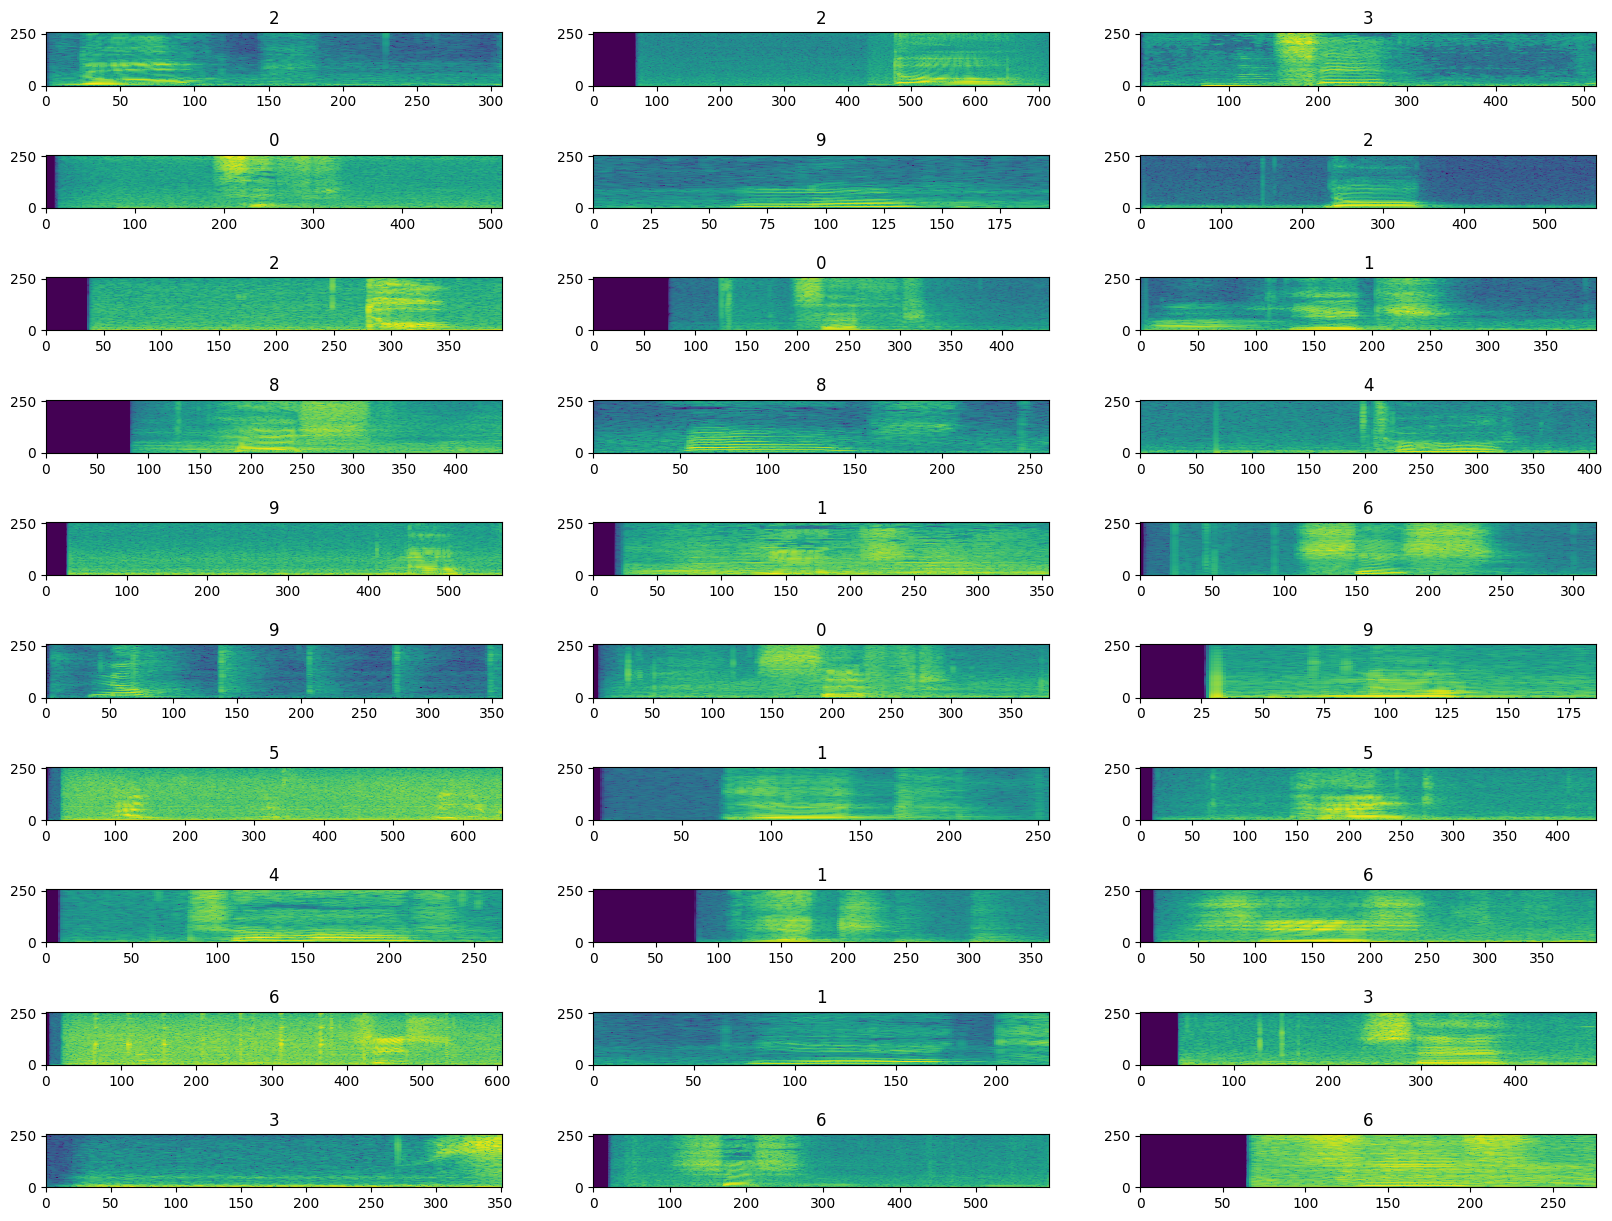

In [ ]:
fig = plt.figure(figsize=(20, 15))
for i, (path, lbl) in enumerate(zip(train_paths, train_labels)):
    if i >= 30: break

    ax = plt.subplot(10, 3, i + 1)
    file = tf.io.read_file(path)
    wav, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    spectrum = tf.abs(tf.signal.stft(wav, frame_length=511, frame_step=64))

    log_spec = np.log(spectrum.numpy().T + np.finfo(np.float32).eps)
    ax.pcolormesh(log_spec)
    ax.set_title(f'{lbl}')

fig.subplots_adjust(hspace=1.3)

## Building a pipeline

In [ ]:
?yamnet_model

In [ ]:
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np

SAMPLE_RATE = 16000
BATCH_SIZE = 32
BUFFER = 10000
AUTOTUNE = tf.data.experimental.AUTOTUNE

from keras.layers import Normalization

norm_layer = Normalization()

def extract_spectrogram(wav_data):
    ''' run YAMNet to extract spectrogram from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    return spectrogram

# def get_spectrogram(waveform):
#     spectrogram = tf.signal.stft(waveform, frame_length=320, frame_step=32)
#     spectrogram = tf.abs(spectrogram)
#     return spectrogram

def load_audio(path):
    file = tf.io.read_file(path)
    wav, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=SAMPLE_RATE)
    return wav


def load_dataset(path, label):
    audio = load_audio(path)
    spectrogram = extract_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    label = tf.one_hot(label, 10)
    return spectrogram, label


train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(load_dataset, num_parallel_calls=AUTOTUNE)

# adapt norm layer
norm_layer.adapt(train_ds.map(lambda x, y: x))
train_ds = train_ds.map(lambda x, y: (norm_layer(x), y))

train_ds = train_ds.cache()
train_ds = train_ds.shuffle(BUFFER)
train_ds = train_ds.padded_batch(BATCH_SIZE, padding_values=(-2.377755, 0.0))
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(load_dataset, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (norm_layer(x), y))
test_ds = test_ds.cache()
test_ds = test_ds.padded_batch(BATCH_SIZE, padding_values=(-2.377755, 0.0))
test_ds = test_ds.prefetch(AUTOTUNE)

In [ ]:
for x, y in train_ds.take(5):
    print(x.shape, y.shape)

(32, 336, 64, 1) (32, 10)
(32, 432, 64, 1) (32, 10)
(32, 384, 64, 1) (32, 10)
(32, 480, 64, 1) (32, 10)
(32, 336, 64, 1) (32, 10)


After processing the data pipeline and extracting spectrograms using YAMNet, we can visualize these spectrograms to gain insights into the features used for audio classification. The following code visualizes the spectrograms from the first 5 batches in the training dataset:

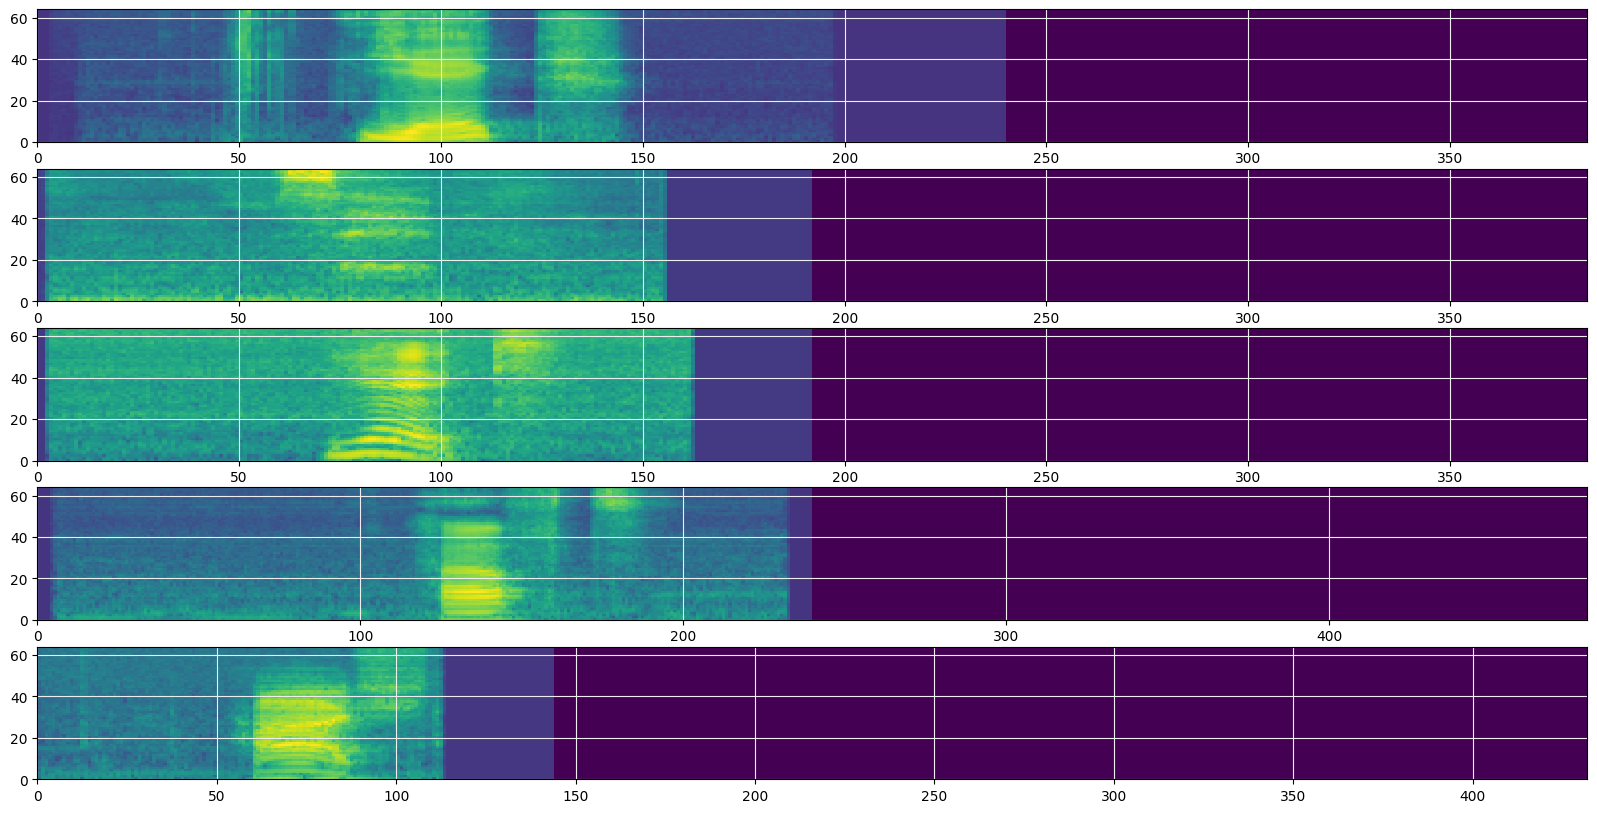

In [ ]:
plt.figure(figsize=(20, 10))
for i, (x, y) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5, 1, i + 1)
    ax.pcolormesh(tf.transpose(tf.squeeze(x[0])))

    ax.grid(c='#eee')
fig.subplots_adjust(hspace=1.3)

# MobileNet:
- **ConvBlock**: A basic convolutional block comprising convolutional, batch normalization, and ReLU activation layers.
  
- **BottleNeck**: A bottleneck block featuring depthwise separable convolution, expansion, projection, and skip connections to reduce computational cost while maintaining effectiveness.

- **MobileNet**: The main model class incorporating resizing, normalization, multiple convolutional and bottleneck layers, global average pooling, dropout regularization, and a dense classifier for final classification output.

The model's architecture is structured to efficiently process and classify images, leveraging techniques like depthwise separable convolutions and residual connections to balance performance and accuracy.

In [ ]:
from keras.layers import Layer, Conv2D, BatchNormalization, Dropout, Activation, Normalization, Input, MaxPool2D, Dense
from keras.layers import GlobalAveragePooling2D, DepthwiseConv2D, Add, Bidirectional, LSTM, Normalization, MultiHeadAttention, ReLU, Resizing
from keras.models import Model
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import F1Score, CategoricalAccuracy, Precision, Recall
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [ ]:
class ConvBlock(Layer):
    def __init__(self, filters, kernel_size=3, momentum=0.99):
        super(ConvBlock, self).__init__()

        self.conv = Conv2D(filters=filters,
                           kernel_size=kernel_size,
                           padding='same',
                           name='conv')

        self.bn = BatchNormalization(momentum=momentum,
                                     name='bn')

        # self.act = ReLU(max_value=6,
        #                 name='act')
        self.act = Activation(activation='relu', name='act')

    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        x = self.act(x)
        return x

In [ ]:
class BottleNeck(Layer):
    def __init__(self, out_channel=None, kernel_size=3, stride=1, expansion_factor=6, momentum=0.99):
        super(BottleNeck, self).__init__()

        self.momentum = momentum
        self.expansion_factor = expansion_factor
        self.out_channel = out_channel
        self.stride = stride

        self.depthwise = DepthwiseConv2D(kernel_size=kernel_size,
                                         strides=stride,
                                         padding='same',
                                         use_bias=False,
                                         name='depthwise')

        self.bn_depthwise = BatchNormalization(momentum=momentum, name='depthwise_bn')
        self.bn_expand = BatchNormalization(momentum=momentum, name='expand_bn')
        self.bn_project = BatchNormalization(momentum=momentum, name='project_bn')
        self.bn_skip = BatchNormalization(momentum=momentum, name='skip_bn')

        self.act = ReLU(max_value=6,
                        name='relu_act')
        self.add = Add(name='add')


    def build(self, input_shape):
        depth = input_shape[-1]
        self.out_channel = depth if self.out_channel is None else self.out_channel

        self.expand = Conv2D(filters=self.expansion_factor * depth,
                             kernel_size=1,
                             padding='same',
                             use_bias=False,
                             name='expand_conv')

        self.project = Conv2D(filters=self.out_channel,
                              kernel_size=1,
                              padding='same',
                              use_bias=False,
                              name='project_conv')

        self.skip_connection = Conv2D(filters=self.out_channel,
                                      kernel_size=1,
                                      name='skip')
        self.built = True


    def call(self, input_tensor, training=False):
        x = self.expand(input_tensor)
        x = self.bn_expand(x, training=training)
        x = self.act(x)

        x = self.depthwise(x)
        x = self.bn_depthwise(x, training=training)
        x = self.act(x)

        x = self.project(x)
        x = self.bn_project(x, training=training)

        if self.stride == 1:
            skip = self.skip_connection(input_tensor)
            skip = self.bn_skip(skip, training=training)
            x = self.add([x, skip])

        return x

In [ ]:
class MobileNet(Model):
    def __init__(self, num_classes, momentum=0.99):
        super(MobileNet, self).__init__()

        self.resize = Resizing(250, 64)
        self.normalize = Normalization()

        self.conv1 = ConvBlock(filters=64, kernel_size=3, momentum=momentum)

        self.bottlenecks1 = [BottleNeck(out_channel=64,
                                        stride=2 if i == 0 else 1,
                                        expansion_factor=4, momentum=momentum)
                             for i in range(3)]

        self.bottlenecks2 = [BottleNeck(out_channel=128,
                                        stride=2 if i == 0 else 1,
                                        expansion_factor=4, momentum=momentum)
                             for i in range(4)]


        self.bottlenecks3 = [BottleNeck(out_channel=256,
                                        stride=2 if i == 0 else 1,
                                        expansion_factor=4, momentum=momentum)
                             for i in range(4)]



        self.conv2 = ConvBlock(filters=512, kernel_size=1, momentum=momentum)

        self.global_avg = GlobalAveragePooling2D(name='global_avg')
        self.dropout = Dropout(0.8, name='dropout')
        self.classifier = Dense(num_classes)


    def build(self, input_shape):
        inputs = Input(shape=input_shape)
        self.call(inputs)
        self.built = True


    def call(self, input_tensor, training=False):
        x = self.resize(input_tensor)
        # x = self.normalize(x)
        x = self.conv1(x, training=training)

        for bottleneck in self.bottlenecks1:
            x = bottleneck(x, training=training)

        for bottleneck in self.bottlenecks2:
            x = bottleneck(x, training=training)

        for bottleneck in self.bottlenecks3:
            x = bottleneck(x, training=training)

        x = self.conv2(x, training=training)
        x = self.global_avg(x)
        x = self.dropout(x, training=training)
        x = self.classifier(x)
        return x

In [ ]:
model = MobileNet(10, momentum=0.4)
model.build(input_shape=x.shape[1:])
model.summary()

Model: "mobile_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 250, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_2 (Normalization)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_block (ConvBlock)               │ (None, 250, 64, 64)         │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottle_neck (BottleNeck)             │ (None, 125, 32, 64)         │          37,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottle_neck_1 (BottleNeck)           │ (None, 125, 32, 64)         │          41,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottle_neck_2 (BottleNeck)           │ (None, 125, 32, 64)         │          41,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottle_neck_3 (BottleNeck)           │ (None, 63, 16, 128)         │          54,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottle_neck_4 (BottleNeck)           │ (None, 63, 16, 128)         │         157,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottle_neck_5 (BottleNeck)           │ (None, 63, 16, 128)         │         157,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottle_neck_6 (BottleNeck)           │ (None, 63, 16, 128)         │         157,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottle_neck_7 (BottleNeck)           │ (None, 32, 8, 256)          │         206,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottle_neck_8 (BottleNeck)           │ (None, 32, 8, 256)          │         609,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottle_neck_9 (BottleNeck)           │ (None, 32, 8, 256)          │         609,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottle_neck_10 (BottleNeck)          │ (None, 32, 8, 256)          │         609,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_block_1 (ConvBlock)             │ (None, 32, 8, 512)          │         133,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg (GlobalAveragePooling2D)  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,821,514 (10.76 MB)

 Trainable params: 2,789,770 (10.64 MB)

 Non-trainable params: 31,744 (124.00 KB)

## Train The Model

In [ ]:
model.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(1e-3),
    metrics=['accuracy']
)

def get_scheduler(initial_learning_rate, weight=0.95, min_learning_rate=1e-5):
    def func(epoch):
        return max(min_learning_rate, initial_learning_rate * weight ** epoch)
    return func


scheduler = get_scheduler(1e-3, weight=0.92)
lr_scheduler = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint('./checkpoints/mobilenet/best.weights.h5',
                             save_best_only=True,
                             save_weights_only=True)

callbacks = [lr_scheduler, checkpoint]

In [ ]:
history = model.fit(train_ds, epochs=60, validation_data=test_ds, callbacks=callbacks)

## Evaluation

In [ ]:
def plot(history, key, ax):
    val_key = 'val_' + key
    ax.plot(history.epoch, history.history[key], label=key)
    ax.plot(history.epoch, history.history[val_key], label=val_key)
    ax.grid(c='#eee')
    ax.set_title(f'{key.capitalize()} per epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel(f'{key}')
    plt.legend();

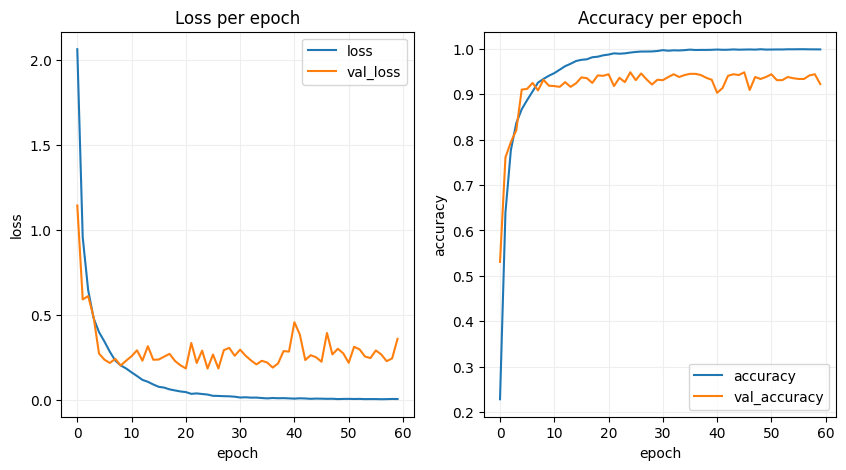

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = plt.subplot(1, 2, 1)
plot(history, 'loss', ax);

ax = plt.subplot(1, 2, 2)
plot(history, 'accuracy', ax);

In [ ]:
model.load_weights('checkpoints/mobilenet/best.weights.h5')

In [ ]:
model.evaluate(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9450 - loss: 0.1542


[0.19832994043827057, 0.9295393228530884]

In [ ]:
def load_dataset_inference(path):
    audio = load_audio(path)
    spectrogram = extract_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    spectrogram = tf.expand_dims(spectrogram, axis=0)
    inp = norm_layer(spectrogram)
    return inp

In [ ]:
for i in range(10):
  path = f'test/My_{i}.wav'
  inp = load_dataset_inference(path)
  r = model.predict(inp, verbose=0)
  print(path , ": ",np.argmax(r))

test/My_0.wav :  0
test/My_1.wav :  1
test/My_2.wav :  2
test/My_3.wav :  3
test/My_4.wav :  4
test/My_5.wav :  5
test/My_6.wav :  6
test/My_7.wav :  7
test/My_8.wav :  8
test/My_9.wav :  9


In [ ]:
inp = load_dataset_inference('/content/2/2_1124.wav')
r = model.predict(inp)
print(np.argmax(r))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
2


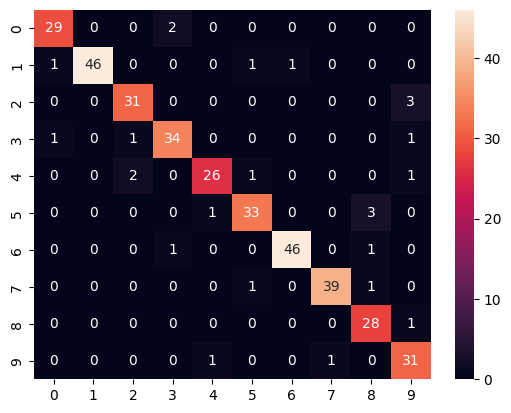

In [ ]:
from sklearn.metrics import classification_report

pred = model.predict(test_ds, verbose=0)
pred = tf.argmax(pred, axis=-1)

y_true = tf.concat([tf.argmax(l, axis=-1) for s, l in test_ds], axis=-1)

conf_matrix = tf.math.confusion_matrix(y_true, pred)

classes = [str(i) for i in range(10)]
sns.heatmap(conf_matrix, annot=True, xticklabels=classes, yticklabels=classes, fmt='g');

In [ ]:
print(classification_report(y_true, pred, target_names=classes))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        31
           1       1.00      0.94      0.97        49
           2       0.91      0.91      0.91        34
           3       0.92      0.92      0.92        37
           4       0.93      0.87      0.90        30
           5       0.92      0.89      0.90        37
           6       0.98      0.96      0.97        48
           7       0.97      0.95      0.96        41
           8       0.85      0.97      0.90        29
           9       0.84      0.94      0.89        33

    accuracy                           0.93       369
   macro avg       0.93      0.93      0.93       369
weighted avg       0.93      0.93      0.93       369



## Export Model

In [ ]:
class ExportModel(tf.Module):
    def __init__(self, model, get_spec):
        super(ExportModel, self).__init__()

        self.model = model
        self.extract_spectrogram = get_spec

    def create_pipeline(self, filenames):
        BATCH_SIZE = tf.cast(tf.shape(filenames)[0], tf.int64)
        AUTOTUNE = tf.data.experimental.AUTOTUNE

        pipeline = tf.data.Dataset.from_tensor_slices(filenames)
        pipeline = pipeline.map(load_audio, num_parallel_calls=AUTOTUNE)
        pipeline = pipeline.map(lambda x: self.extract_spectrogram(x), num_parallel_calls=AUTOTUNE)
        pipeline = pipeline.map(lambda x: norm_layer(x), num_parallel_calls=AUTOTUNE)
        pipeline = pipeline.padded_batch(32)
        pipeline = pipeline.prefetch(AUTOTUNE)
        return pipeline


    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None,])])
    def __call__(self, filenames):
        pipeline = self.create_pipeline(filenames)
        data = next(iter(pipeline))
        predictions = self.model(data, training=False)
        predictions = tf.argmax(predictions, axis=-1)
        return predictions


In [ ]:
exportModel = ExportModel(model, extract_spectrogram)
y_pred = exportModel(tf.convert_to_tensor(test_paths))

for i in range(20):
    print(f'Predicted {y_pred[i]} and the actual label is {test_labels[i]}')
    display(Audio(filename=test_paths[i]))

In [ ]:
model.save('./models/mobile_net.tf')

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('./models/mobile_net.tf/')
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.SELECT_TF_OPS,
    tf.lite.OpsSet.TFLITE_BUILTINS
]

converter._experimental_lower_tensor_list_ops = False
tflite = converter.convert()

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 90, Total Ops 147, % non-converted = 61.22 %
 * 90 ARITH ops

- arith.constant:   90 occurrences  (f32: 88, i32: 2)



  (f32: 8)
  (f32: 32)
  (f32: 11)
  (f32: 1)
  (f32: 1)
  (f32: 1)


In [ ]:
with open('./models/mobile_net_tflite.tflite', 'wb') as writer:
    writer.write(tflite)